In [2]:
# set env LD_LIBRARY_PATH to install_path
install_path = "/Users/yumengxu/Project/Physics/cwb/cwb_source/tools/install/lib"

import os

os.environ['LD_LIBRARY_PATH'] = install_path
os.environ['HOME_WAT_FILTERS'] = '/usr/local/anaconda3/envs/cwb/lib/python3.11/site-packages/pycwb/shared'

from pycwb import logger_init
logger_init()

# load user parameters
from pycwb.config import Config, CWBConfig
# cwb_config = CWBConfig('./config.ini')
# cwb_config.export_to_envs()

config = Config('./user_parameters.yaml')
config.ifo

['L1', 'H1', 'V1']

In [3]:
# load noise from gwf
from pycwb.modules.read_data import read_from_gwf, generate_noise
# noise = [read_from_gwf(i, config, f"frames/L1H1V1-SimStrain-9311/{ifo}-SimStrain-931158100-600.gwf", config.channelNamesRaw[i], None, None ) for i, ifo in enumerate(config.ifo)]

noise = [generate_noise(f_low=30.0, sample_rate=1024.0, duration=600, start_time = 931158100, seed=i)
         for i, ifo in enumerate(config.ifo)]

2023-02-07 17:04:58,924 - pycwb.modules - INFO - WDM not found, loading wavelet library


In [4]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                         mass1=20,
                         mass2=20,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         distance=500,
                         delta_t=1.0/noise[0].sample_rate,
                         f_lower=20)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158400
from pycwb.modules.read_data import project_to_detector
strain = project_to_detector(hp, hc, right_ascension, declination, polarization, config.ifo, gps_end_time)

In [5]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp2, hc2 = get_td_waveform(approximant="IMRPhenomPv3",
                           mass1=20,
                           mass2=20,
                           spin1z=0.9,
                           spin2z=0.4,
                           inclination=1.23,
                           coa_phase=2.45,
                           distance=500,
                           delta_t=1.0/noise[0].sample_rate,
                           f_lower=20)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158390
from pycwb.modules.read_data import project_to_detector
strain2 = project_to_detector(hp2, hc2, right_ascension, declination, polarization, config.ifo, gps_end_time)

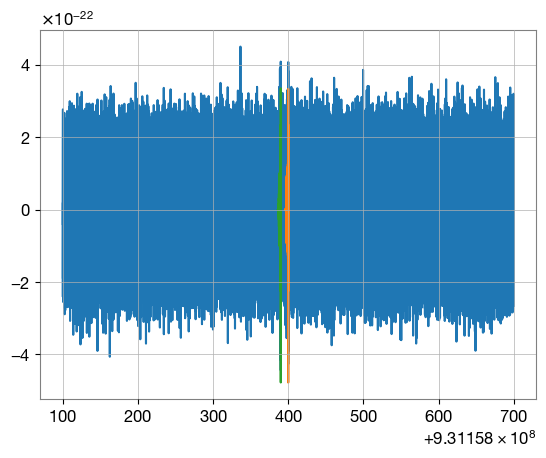

In [7]:
# inject signal into noise and convert to wavearray
injected_0 = [noise[i].add_into(strain[i]) for i in range(len(config.ifo))]
injected = [injected_0[i].add_into(strain2[i]) for i in range(len(config.ifo))]

injected[0].plot()
strain[0].plot()
strain2[0].plot()

Filter length = 577,  norm = 0.9999999947541458


input_line_69:2:15: warning: instantiation of variable 'WDM<double>::Cos' required here, but no definition is available [-Wundefined-var-template]
 WDM<double>::Cos;
              ^
/Users/yumengxu/Project/Physics/cwb/cwb_source/wat/WDM.hh:137:19: note: forward declaration of template entity is here
   static double *Cos[MAXBETA], *Cos2[MAXBETA], *SinCos[MAXBETA];
                  ^
input_line_69:2:15: note: add an explicit instantiation declaration to suppress this warning if 'WDM<double>::Cos' is explicitly instantiated in another translation unit
 WDM<double>::Cos;
              ^
input_line_70:2:15: warning: instantiation of variable 'WDM<double>::Cos2' required here, but no definition is available [-Wundefined-var-template]
 WDM<double>::Cos2;
              ^
/Users/yumengxu/Project/Physics/cwb/cwb_source/wat/WDM.hh:137:34: note: forward declaration of template entity is here
   static double *Cos[MAXBETA], *Cos2[MAXBETA], *SinCos[MAXBETA];
                                 ^
inpu

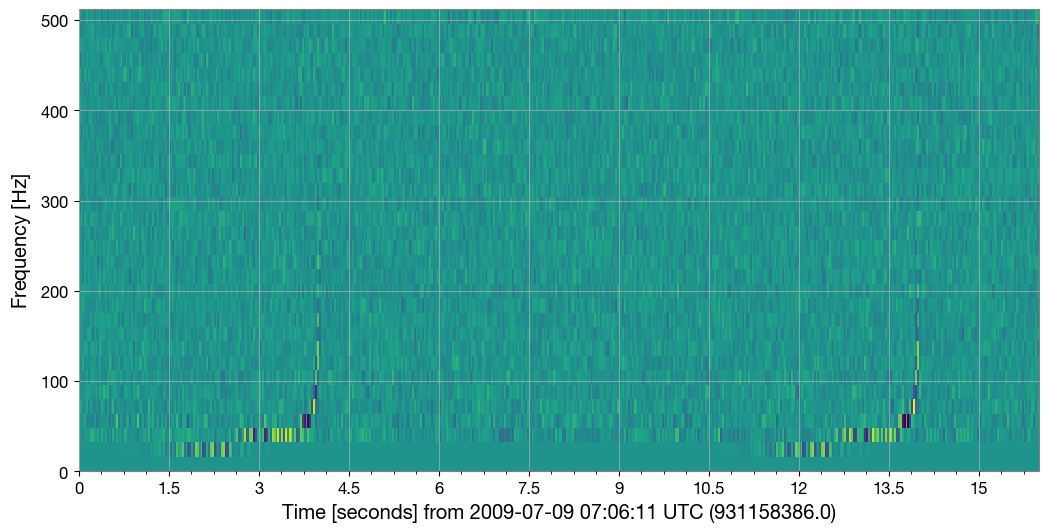

In [8]:
from pycwb.utils import convert_pycbc_timeseries_to_wavearray
wavearray = [convert_pycbc_timeseries_to_wavearray(d) for d in injected]

from pycwb.modules.plot import plot_spectrogram

plot_spectrogram(wavearray[0], xmin = gps_end_time-4, xmax = gps_end_time+12)

Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 1537,  norm = 0.9999999999707183
Filter length = 577,  norm = 0.9999999947541458


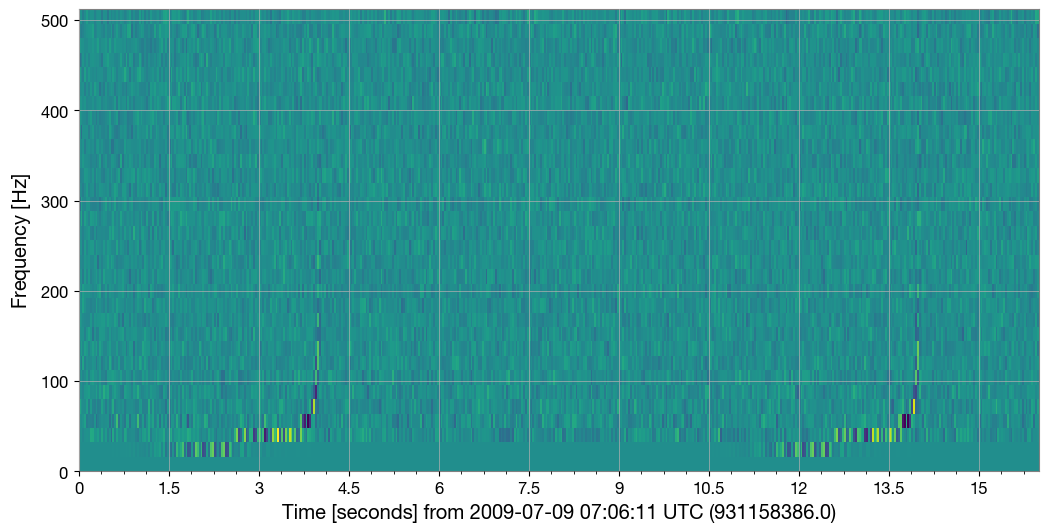

In [9]:
# data conditioning
from pycwb.modules.data_conditioning import regression, whitening
data_reg = [regression(config, wavearray[i]) for i in range(len(config.ifo))]

plot_spectrogram(data_reg[0], xmin = gps_end_time-4, xmax = gps_end_time+12)

2023-02-07 17:06:10,251 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 17:06:10,301 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 17:06:10,302 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 17:06:10,315 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 17:06:10,474 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 17:06:10,514 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 17:06:10,515 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 17:06:10,521 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries
2023-02-07 17:06:10,644 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 17:06:10,680 - pycwb.modules.data_conditioning.whitening - INFO - high pass filterin

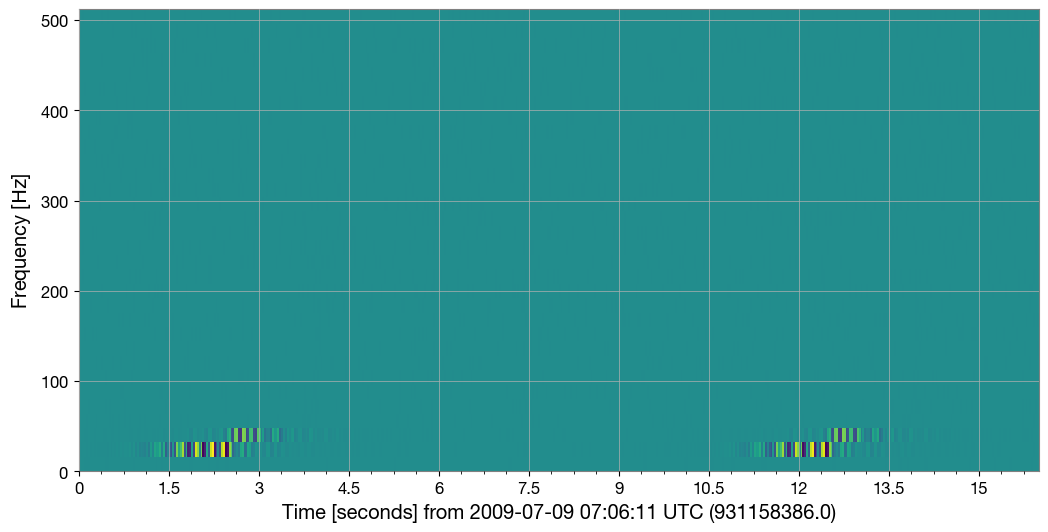

In [10]:
data_w_reg = [whitening(config, data_reg[i]) for i in range(len(config.ifo))]
tf_map = [d['TFmap'] for d in data_w_reg]

plot_spectrogram(data_w_reg[0]['TFmap'], xmin = gps_end_time-4, xmax = gps_end_time+12)

In [11]:
# initialize network
from pycwb.modules.coherence import create_network
net, wdm_list = create_network(1, config, data_w_reg)

2023-02-07 17:06:59,173 - pycwb.modules.coherence.network - INFO - Loading MRA
2023-02-07 17:06:59,247 - pycwb.modules.coherence.network - INFO - Filter length = 3.0009765625 (sec)
2023-02-07 17:06:59,382 - pycwb.modules.coherence.network - INFO - Filter length = 1.5009765625 (sec)
2023-02-07 17:06:59,429 - pycwb.modules.coherence.network - INFO - Filter length = 0.7509765625 (sec)
2023-02-07 17:06:59,477 - pycwb.modules.coherence.network - INFO - Filter length = 0.3759765625 (sec)
2023-02-07 17:06:59,527 - pycwb.modules.coherence.network - INFO - Filter length = 0.1884765625 (sec)
2023-02-07 17:06:59,579 - pycwb.modules.coherence.network - INFO - Filter length = 0.0947265625 (sec)
2023-02-07 17:06:59,580 - pycwb.modules.coherence.network - INFO - Initializing network
2023-02-07 17:06:59,580 - pycwb.modules.coherence.network - INFO - Adding ifo L1
2023-02-07 17:06:59,603 - pycwb.modules.coherence.network - INFO - Adding ifo H1
2023-02-07 17:06:59,607 - pycwb.modules.coherence.network -

In [12]:
# calculate coherence
## max energy
from pycwb.modules.coherence import max_energy
alp_list = max_energy(config, net, tf_map, wdm_list)

In [13]:
## threshold
from pycwb.modules.coherence import threshold
threshold_list = threshold(config, net, alp_list)

2023-02-07 17:07:16,525 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=56328.8 Emax=112658
2023-02-07 17:07:16,526 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:0-THR:56328.81587137041
2023-02-07 17:07:16,534 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 584
2023-02-07 17:07:17,064 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=56328.8 Emax=112658
2023-02-07 17:07:17,065 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:1-THR:56328.81587137041
2023-02-07 17:07:17,066 - pycwb.modules.coherence.threshold - INFO - live time in zero lag: 584
2023-02-07 17:07:17,591 - pycwb.modules.coherence.threshold - INFO - thresholds in units of noise variance: Eo=56328.8 Emax=112658
2023-02-07 17:07:17,592 - pycwb.modules.coherence.threshold - INFO - cwb2G::Coherence -RES:2-THR:56328.81587137041
2023-02-07 17:07:17,594 - pycwb.modules.coherence.threshold - INFO - l

In [14]:
## select pixels
from pycwb.modules.coherence import select_pixels
sparse_table_list = select_pixels(config, net, tf_map, wdm_list, threshold_list)

2023-02-07 17:07:19,375 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 17:07:19,435 - pycwb.modules.coherence.select_pixels - INFO -   0|        4|    613 
2023-02-07 17:07:19,702 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 17:07:19,711 - pycwb.modules.coherence.select_pixels - INFO -   0|        4|    613 
2023-02-07 17:07:19,768 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 17:07:19,778 - pycwb.modules.coherence.select_pixels - INFO -   0|        4|    613 
2023-02-07 17:07:19,836 - pycwb.modules.coherence.select_pixels - INFO - lag|clusters|pixels 
lag:  0
pixels selected
wc got
net pattern:  0
2023-02-07 17:07:19,846 - pycwb.modules.coherence.select_pixels - INFO -   0|        4|    613 
2023-02-07 17:07:19,906 - pycwb.modules.coherence.se